# Full Model Fine-Tuning

This notebook enables you to fine-tune pretrained language models (PLMs) on your own datasets.

To improve efficiency and performance, we employed Parameter-Efficient Fine-Tuning (PEFT) using LoRA (Low-Rank Adaptation of Large Language Models) as described in the other colab file.


Note: In this example, we use the relatively small ESM2 8M model to achieve faster training on a single T4 GPU in Google Colab. Larger models or longer sequence lengths will require more GPU memory and significantly longer training times.

# Install Packages

In [1]:
# !pip install datasets
# !pip install evaluate
# !pip install SentencePiece
# !pip install transformers[torch]
# !pip install peft
# !pip install Biopython
# !pip install mpi4py

In [2]:
import torch
import numpy as np
import pandas as pd
import transformers
import datasets as datasets

print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.2.0+cu118
Cuda version:  11.8
Numpy version:  1.26.4
Pandas version:  2.2.2
Transformers version:  4.51.3
Datasets version:  3.6.0


In [3]:
import torch, numpy as np, random

seed = 21
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load training data

In [4]:
import pandas as pd
from Bio import SeqIO
import requests
from io import StringIO

# GitHub raw link
url = 'https://raw.githubusercontent.com/MirTanveer/Fine-Tune-TF/main/Data/First_layer_training.txt'

# Fetch the data from GitHub
response = requests.get(url)
response.raise_for_status()  # ensure the download worked

# Parse the FASTA data from the text
sequences = []
for record in SeqIO.parse(StringIO(response.text), "fasta"):
    # Example header format: >seq1%someinfo%LABEL=1
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extract numeric label
    sequences.append([record.name, str(record.seq), label])

# Create a DataFrame
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display
print(df.head())
print("\nTotal sequences:", len(df))


     name                                           sequence  label
0  Q9H161  MNAETCVSYCESPAAAMDAYYSPVSQSREGSSPFRAFPGGDKFGTT...      1
1  Q9HBZ2  MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...      1
2  E9PKN1  MADQRMDISSTISDFMSPGPTDLLSSSLGTSGVDCNRKRKGSSTDY...      1
3  P50553  MESSAKMESGGAGQQPQPQPQQPFLPPAACFFATAAAAAAAAAAAA...      1
4  P15336  MKFKLHVNSARQYKDLWNMSDDKPFLCTAPGCGQRFTNEDHLAVHK...      1

Total sequences: 832


In [5]:
from datasets import Dataset
# Convert label column to int (already done)
df['label'] = df['label'].astype(int)

# Optional: Map label to class names if needed
label2id = {label: i for i, label in enumerate(sorted(df['label'].unique()))}
id2label = {i: label for label, i in label2id.items()}

# Convert dataframe to HuggingFace dataset
dataset = Dataset.from_pandas(df)

In [6]:
type(dataset)

datasets.arrow_dataset.Dataset

# Custom Head Classifier

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class CustomHeadClassifier(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout, num_classes):
        super(CustomHeadClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, attention_mask=None):
        # x shape: (batch_size, seq_len, embedding_size)
        if attention_mask is not None:
            # masked mean pooling
            mask = attention_mask.unsqueeze(-1)  # (batch_size, seq_len, 1)
            x = (x * mask).sum(1) / mask.sum(1)
        else:
            x = x.mean(dim=1)  # mean pooling over sequence
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
#Load tokenzier and model

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "facebook/esm2_t6_8M_UR50D"  # or other ESM-2 variant

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification"
)

embedding_size = model.config.hidden_size
model.classifier = CustomHeadClassifier(embedding_size, hidden_size=128, dropout=0.3, num_classes=2)
model = model.to("cuda:0")

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Freeze classification head
# for param in model.classifier.parameters():
#     param.requires_grad = False

In [10]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [11]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())

print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {all_params:,}")

Trainable parameters: 7,778,747
Total parameters: 7,778,747


In [12]:
def tokenize_function(example):
    return tokenizer(example["sequence"], truncation=True, padding="max_length", max_length=1024)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [13]:
# ds_config = {
#   "train_batch_size": "auto",
#   "gradient_accumulation_steps": "auto",
#   "fp16": {
#     "enabled": True
#   },
#   "zero_optimization": {
#     "stage": 2,
#     "offload_optimizer": {
#       "device": "cpu",
#       "pin_memory": True
#     },
#     "overlap_comm": True
#   },
#   "gradient_clipping": 1.0
# }

In [14]:
trainable = [name for name, param in model.named_parameters() if param.requires_grad]
frozen = [name for name, param in model.named_parameters() if not param.requires_grad]

print(f"Trainable layers: {len(trainable)}")
print(trainable[:5])  # print a few

print("\n")

print(f"Frozen layers: {len(frozen)}")
print(frozen[:5])  # print a few



from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./ESM2-8M-with-Finetune",
    logging_dir="./logs",
    learning_rate=1e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8, #Effective gradient_accumulation is 8
    num_train_epochs=10,
    eval_steps=500,
    logging_steps=100,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    warmup_ratio=0.05,
    max_grad_norm=1.0,
    fp16=True,
    #deepspeed= ds_config,
    report_to="none"
)

Trainable layers: 106
['esm.embeddings.word_embeddings.weight', 'esm.embeddings.position_embeddings.weight', 'esm.encoder.layer.0.attention.self.query.weight', 'esm.encoder.layer.0.attention.self.query.bias', 'esm.encoder.layer.0.attention.self.key.weight']


Frozen layers: 0
[]


In [15]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

In [16]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [17]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.670000,0.645096,0.742515
2,0.549700,0.471218,0.868263
3,0.385900,0.378791,0.880240
4,0.324400,0.348621,0.880240
5,0.288200,0.349153,0.880240
6,0.261600,0.336935,0.880240
7,0.249800,0.348358,0.874251
8,0.236200,0.313757,0.892216
9,0.231500,0.323966,0.880240


TrainOutput(global_step=830, training_loss=0.3445307122655662, metrics={'train_runtime': 226.9314, 'train_samples_per_second': 29.304, 'train_steps_per_second': 3.657, 'total_flos': 300638240311296.0, 'train_loss': 0.3445307122655662, 'epoch': 9.890225563909775})

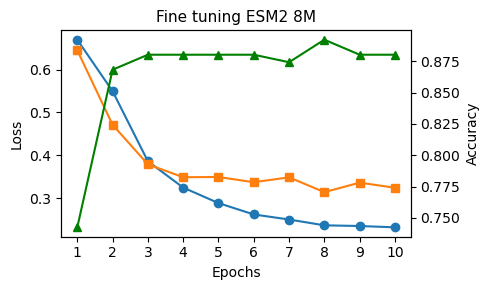

In [18]:
import matplotlib.pyplot as plt

train_loss, eval_loss, eval_accuracy, epochs = [], [], [], []

for entry in trainer.state.log_history:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append(entry["eval_accuracy"])
    if "epoch" in entry:
        epochs.append(entry["epoch"])

# Make sure x-axis aligns
x = list(range(1, len(train_loss)+1))

fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot loss curves on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(x, train_loss,   marker='o')
ax1.plot(x, eval_loss,   marker='s')
ax1.set_xticks(x)
ax1.tick_params(axis='y')

# Instantiate a second axes sharing the same x-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')
ax2.plot(x, eval_accuracy, color='green', marker='^')
ax2.tick_params(axis='y')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
#ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')
#ax2.set_ylim(0.8, 0.95)
plt.title('Fine tuning ESM2 8M', fontsize=11)
#plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Directory to save
# Save model, tokenzier, and Custom Head Classifier separately
# The standard save_pretrained method from Transformers won’t automatically save the custom head class code.
# We need to save both the model weights and the custom head properly.

save_dir = "Saved_Models/fine_tuned_ESM2_8M_model_with_a_custom_head"

# Save Hugging Face model weights (excluding custom head)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

# Save custom head weights separately
torch.save(model.classifier.state_dict(), f"{save_dir}/custom_head.pt")

## Load the saved model

In [20]:
#Load the Saved Model

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch.nn as nn
import torch.nn.functional as F

class CustomHeadClassifier(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout, num_classes):
        super(CustomHeadClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, attention_mask=None):
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1)
            x = (x * mask).sum(1) / mask.sum(1)
        else:
            x = x.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [21]:
save_dir = "Saved_Models/fine_tuned_ESM2_8M_model_with_a_custom_head"
tokenizer = AutoTokenizer.from_pretrained(save_dir)
model_load = AutoModelForSequenceClassification.from_pretrained(save_dir, num_labels=2)
embedding_size = model_load.config.hidden_size
model_load.classifier = CustomHeadClassifier(embedding_size, hidden_size=128, dropout=0.3, num_classes=2)

# Load the trained weights
model_load.classifier.load_state_dict(torch.load(f"{save_dir}/custom_head.pt"))

# Move to GPU if needed
model_load = model_load.to("cuda:0")
model_load.eval()  # set to evaluation mode

Some weights of the model checkpoint at Saved_Models/fine_tuned_ESM2_8M_model_with_a_custom_head were not used when initializing EsmForSequenceClassification: ['classifier.fc1.bias', 'classifier.fc1.weight', 'classifier.fc2.bias', 'classifier.fc2.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at Saved_Models/fine_tuned_ESM2_8M_model_with_a_custom_head and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05,

In [22]:
# Check if CUDA is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load independent dataset

In [23]:
import pandas as pd
from Bio import SeqIO
import requests
from io import StringIO

# GitHub raw link
url = 'https://raw.githubusercontent.com/MirTanveer/Fine-Tune-TF/main/Data/First_Layer_Independent.txt'

# Fetch the data from GitHub
response = requests.get(url)
response.raise_for_status()  # ensure the download worked

# Parse the FASTA data from the text
sequences = []
for record in SeqIO.parse(StringIO(response.text), "fasta"):
    # Example header format: >seq1%someinfo%LABEL=1
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extract numeric label
    sequences.append([record.name, str(record.seq), label])

# Create a DataFrame
df_test= pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display
print(df_test.head())
print("\nTotal sequences:", len(df_test))


     name                                           sequence  label
0  A6NJG6  MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...      1
1  Q96QS3  MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...      1
2  Q8N100  MKSCKPSGPPAGARVAPPCAGGTECAGTCAGAGRLESAARRRLAAN...      1
3  Q9NY43  MTMEGASGSSFGIDTILSSASSGSPGMMNGDFRPLGEARTADFRSQ...      1
4  Q96T88  MWIQVRTMDGRQTHTVDSLSRLTKVEELRRKIQELFHVEPGLQRLF...      1

Total sequences: 212


In [24]:
from datasets import Dataset

df_test["label"] = df_test["label"].astype(int)
test_dataset = Dataset.from_pandas(df_test)

In [25]:
def tokenize_function(example):
    return tokenizer(example["sequence"], padding="max_length", truncation=True, max_length=1024)

test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

In [26]:
# Create Trainer again for evaluation
# trainer_loaded = Trainer(model=model, tokenizer=tokenizer)
# predictions = trainer_loaded.predict(test_dataset)

In [27]:
from transformers import Trainer

trainer = Trainer(model=model_load, tokenizer=tokenizer)

predictions = trainer.predict(test_dataset)

C:\Users\default.DESKTOP-TP42RLP\AppData\Local\Temp\ipykernel_32672\1707723771.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_load, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [28]:
import numpy as np
import torch.nn.functional as F
logits = predictions.predictions
labels = predictions.label_ids
preds = np.argmax(logits, axis=-1)
probs = F.softmax(torch.tensor(logits), dim=-1).numpy()  # shape: [N, num_classes]

In [29]:
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(labels, preds)
print(f"Test Accuracy: {acc:.4f}")

# Optional: detailed report
print(classification_report(labels, preds))

Test Accuracy: 0.8915
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       106
           1       0.87      0.92      0.89       106

    accuracy                           0.89       212
   macro avg       0.89      0.89      0.89       212
weighted avg       0.89      0.89      0.89       212



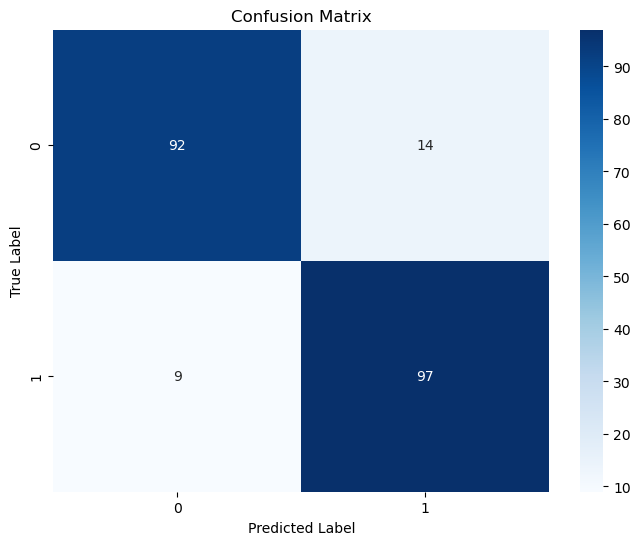

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
auc = roc_auc_score(labels, probs[:, 1])
print(f"AUC Score (Binary): {auc:.4f}")

AUC Score (Binary): 0.9353


In [32]:
TN, FP, FN, TP = cm.ravel()

In [33]:
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
specificity= TN / (TN + FP) if (TN + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall = Sensitivity
# Matthews correlation coefficient
import numpy as np
numerator = (TP * TN) - (FP * FN)
denominator = np.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))
mcc = numerator / denominator if denominator > 0 else 0
F1_score= (2*precision*recall)/(precision+recall)

In [34]:
print("Precision value is: ", precision)
print("Specificity value is: ", specificity)
print("Recall value is: ", recall)
print("Mcc score is: ", mcc)
print("F1 Score is: ", F1_score)

Precision value is:  0.8738738738738738
Specificity value is:  0.8679245283018868
Recall value is:  0.9150943396226415
Mcc score is:  0.7838914292818965
F1 Score is:  0.8940092165898619
